In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy.random as rn
from tqdm.notebook import tqdm
from numba import int32, float64, njit
from numba.experimental import jitclass
from numba_progress import ProgressBar
import matplotlib.dates as mdates

In [3]:
#from GARCH import GARCH

In [4]:
data = pd.read_csv("returns_data.csv", index_col = 0)[1:]
data.index = pd.to_datetime(data.index)
cov = pd.read_csv("cov_mat.csv", index_col=0).to_numpy()
mean = pd.read_csv("mean_vec.csv", index_col = 0).to_numpy()
(n,_) = cov.shape 

In [5]:
def covariance_to_correlation(cov_matrix):
    """
    Convert a covariance matrix to a correlation matrix.

    Parameters:
    cov_matrix (np.ndarray): The covariance matrix.

    Returns:
    np.ndarray: The correlation matrix.
    """
   
    cov_matrix = np.asarray(cov_matrix)
    
    # Compute the standard deviations (sqrt of the diagonal elements)
    std_dev = np.sqrt(np.diag(cov_matrix))
    
    # Compute the outer product of standard deviations
    outer_std_dev = np.outer(std_dev, std_dev)
    
    # Compute the correlation matrix
    correlation_matrix = cov_matrix / outer_std_dev
    
    # Handle numerical stability: setting diagonal elements to 1
    np.fill_diagonal(correlation_matrix, 1.0)
    
    return correlation_matrix

def generate_random_correlation_matrix(n):
    A = (rn.normal(size = n**2).reshape(n,-1))
    V = A.T @ A
    W = st.wishart(df = n, scale = V).rvs()
    return covariance_to_correlation(W)

def upper_triangle_flattened_excluding_diagonal(matrix):
    # Get the indices for the upper triangle, excluding the diagonal
    upper_triangle_indices = np.triu_indices_from(matrix, k=1)
    
    # Extract the upper triangle values using the indices
    flattened_array = matrix[upper_triangle_indices]
    
    return flattened_array

## Simulation Hyperparams

In [6]:
n = 5
rho_zero = generate_random_correlation_matrix(n=n)

mu_zero = rn.normal(loc = 2e-4, scale = 1e-4, size =n)

### DCC

Iteration:      5,   Func. Count:     60,   Neg. LLF: 17137871803897.113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12906.042721369802
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


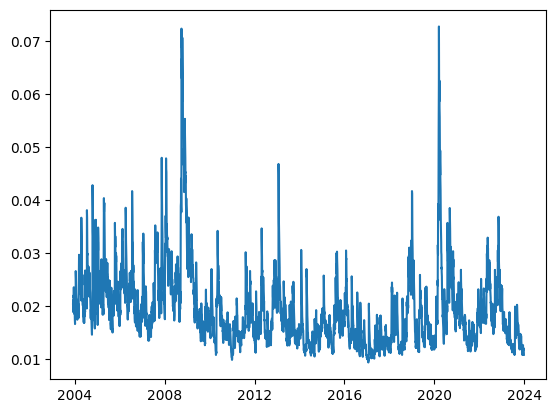

In [7]:
from arch import arch_model
am = arch_model(data['AAPL'], p=1, o=0, q=1, rescale=False)
res_good = am.fit(update_freq=5)
plt.plot(res_good.conditional_volatility)

## Simulate Values

In [8]:
@njit
def cholesky_decomposition(matrix):
    """Compute the Cholesky decomposition of a matrix."""
    return np.linalg.cholesky(matrix)

@njit
def simulate_multivariate_normal(mean, cov, size):
    """Simulate samples from a multivariate normal distribution."""
    n = len(mean)
    L = cholesky_decomposition(cov)
    samples = np.zeros((size, n))
    for i in range(size):
        z = np.random.randn(n)
        samples[i] = mean + np.dot(L, z)
    return samples

@njit
def simulate_stdt(mean, cov, df, size):
    """Simulate samples from a multivariate normal distribution."""
    n = len(mean)
    L = cholesky_decomposition(cov)
    samples = np.zeros((size, n))
    for i in range(size):
        z = np.random.standard_t(df=df,size=n)
        samples[i] = mean + np.dot(L, z)
    return samples

In [9]:
### simulate cov matrix
@njit
def sim_cov_matrix(n, corr, means, T, burn):

    t1 = T + burn
    
    Qs = np.zeros((t1, n, n))
    Qs[0] = corr

    Rs = np.zeros((t1, n, n))
    Rs[0] = corr

    epsilons = np.ones((t1, n))

    sigmas2 = np.ones((t1,n))

    Hs = np.zeros_like(Rs)
    Hs[0] = Rs[0]

    
    alpha_cov = 0.09
    beta_cov = 0.9
    
    for i in (range(1,t1)):
        Qs[i] = corr * (1- alpha_cov - beta_cov) + alpha_cov * np.outer(epsilons[i-1], epsilons[i-1]) + beta_cov * Qs[i-1]
        Rs[i] = np.diag(np.sqrt ( 1/ np.diag(Qs[i]) ) ) @ Qs[i] @ np.diag(np.sqrt ( 1/ np.diag(Qs[i]) ))
        
        sigmas2[i] = 5e-3 + 0.1 * epsilons[i - 1]**2 + 0.85 * sigmas2[i-1]

        Hs[i] = np.diag(np.sqrt(sigmas2[i])) @ Rs[i] @ np.diag(np.sqrt(sigmas2[i]))
        
        epsilons[i] = simulate_multivariate_normal(mean = np.zeros(n), cov = Hs[i], size = 1)

    return (Qs[burn:], sigmas2[burn:], epsilons[burn:], Rs[burn:], Hs[burn:])
    
(Qs, sigmas2, epsilons, Rs, Hs) = sim_cov_matrix(n, rho_zero, mu_zero, 2000,500)

In [10]:
from arch import arch_model
def get_vol(x):
    am = arch_model(x, p=1, o=0, q=1, rescale=False)
    res = am.fit(update_freq=5)
    return res.conditional_volatility
def devolatize(x):
    am = arch_model(x, p=1, o=0, q=1, rescale=False)
    res = am.fit(update_freq=5)
    return x / res.conditional_volatility

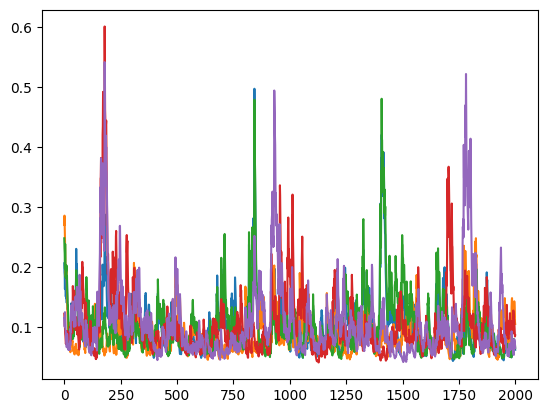

In [11]:
plt.plot(sigmas2)
plt.show()

In [12]:
data_small = data[['AAPL','NVDA', 'MSFT', 'BAC', 'JPM', 'GS', 'PFE','PG', 'F', 'AMZN']]

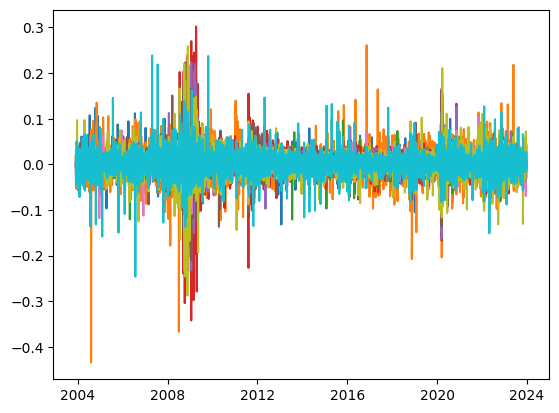

In [13]:
plt.plot(data_small)
plt.show()

In [23]:
corrs = np.load("corrs.npz")
corrs = np.swapaxes(corrs, 0, 2)  # Swap axis 0 and 2
corrs = np.swapaxes(corrs, 1, 2) 

In [24]:
vols = np.sqrt(data_small.apply(get_vol)**2 * 250 )

vols['Markowitz'] = np.load("markowitz_var.npy")

vols['Markowitz_pred'] = np.load("pred_var.npy")

Iteration:      5,   Func. Count:     60,   Neg. LLF: 17137871803897.113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12906.042721369802
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10763.816332414113
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.4159976511416404e+16
Iteration:     10,   Func. Count:    126,   Neg. LLF: 203230935.45545232
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14034.744839686231
            Iterations: 17
            Function evaluations: 166
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     62,   Neg. LLF: 119181062825370.6
Optimization terminated successfully    (Exit mode 0)
            Current

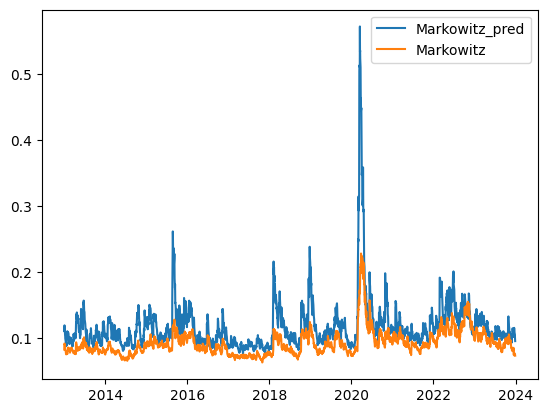

In [25]:
plt.plot(vols.loc['2013':,['Markowitz_pred','Markowitz']], label = ['Markowitz_pred','Markowitz'])
plt.legend()

In [19]:
vols

,AAPL,NVDA,MSFT,BAC,JPM,GS,PFE,PG,F,AMZN,Markowitz,Markowitz_pred
Date,,,,,,,,,,,,
2003-12-03,0.324106,0.420128,0.147021,0.129663,0.159765,0.180268,0.150777,0.119526,0.389945,0.385748,0.142288,5.000000
2003-12-04,0.333841,0.413328,0.146718,0.137081,0.155828,0.198947,0.145899,0.115575,0.383825,0.435329,0.135289,5.000000
2003-12-05,0.317132,0.405375,0.161981,0.137328,0.167675,0.195405,0.152504,0.112185,0.365999,0.408176,0.129584,5.000000
2003-12-08,0.311923,0.415535,0.163986,0.143084,0.178772,0.193565,0.149312,0.112185,0.351743,0.385675,0.124616,5.000000
2003-12-09,0.298665,0.407133,0.165724,0.162244,0.188139,0.191361,0.147102,0.111762,0.348668,0.369363,0.123466,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.185821,0.370168,0.204349,0.320483,0.185212,0.305163,0.390912,0.182339,0.429551,0.306775,0.112511,0.108764
2023-12-26,0.184321,0.364120,0.200712,0.293691,0.178307,0.290369,0.368401,0.169282,0.407219,0.300438,0.108637,0.105158
2023-12-27,0.180671,0.358841,0.197166,0.280713,0.174309,0.276846,0.347139,0.155251,0.388651,0.294642,0.105049,0.101634


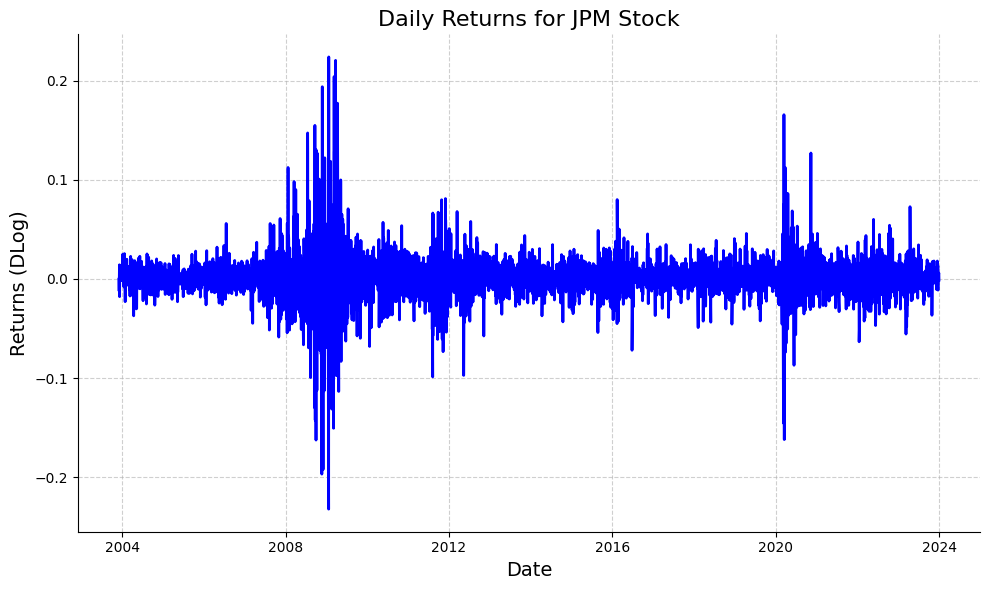

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(data['JPM'], color='blue', linewidth=2)

# Adding a title and labels
plt.title('Daily Returns for JPM Stock', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns (DLog)', fontsize=14)

# Formatting the date on the x-axis


# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Removing top and right borders (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Displaying the plot
plt.tight_layout()
plt.show()